# BigMart - RandomForest (Hyperparameter Tuning)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm, tqdm_notebook

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('final_train.csv')

In [3]:
# LEt's seggregate the target and independent variables first
X = df.drop(columns= 'Item_Outlet_Sales', axis=1)
Y = df['Item_Outlet_Sales']

# Let's scale the independent variables and store them in a dataframe
ss = StandardScaler()
X_scaled = ss.fit_transform(X)
x = pd.DataFrame(X_scaled, columns= X.columns)

# merge the independent and target variables to create a new dataframe with scaled features
scaled_df= pd.concat([x,Y], axis=1)
scaled_df.head(2)

,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Weight_y,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
0,-0.737887,-0.970891,1.763875,0.133879,0.285343,-1.365170,-0.768435,-0.28777,-0.174363,-0.114158,...,-0.344522,-0.350919,-0.35007,-0.350495,2.847938,-0.382818,0.723256,-0.350707,-0.344522,3735.1380
1,1.355222,-0.908348,-1.486518,1.331598,0.285343,1.095912,-1.496059,-0.28777,-0.174363,-0.114158,...,-0.344522,-0.350919,-0.35007,-0.350495,-0.351131,-0.382818,-1.382637,2.851384,-0.344522,443.4228


We will tune the following hyperparamters in the RandomForestRegressor:

* n_estimators
* max_depth
* min_samples_split
* min_samples_leaf

### 1. n_estimators

In [8]:
def estimator_score(data, min_r=1, max_r=10):
    
    X = data.drop(columns = 'Item_Outlet_Sales', axis= 1)
    Y = data['Item_Outlet_Sales']
    
    KF = KFold(n_splits= 5, shuffle= True, random_state= 0)
    
    results= []
    
    for n_est in tqdm_notebook(range(min_r, max_r, 20), desc="Processing", leave=True):
        x = {}
        train_score = []
        val_score = []
        
        for i, (train_index, val_index) in enumerate(KF.split(X, Y)):
            xtr, xval = X.iloc[train_index], X.iloc[val_index]
            ytr, yval = Y.iloc[train_index], Y.iloc[val_index]
        
            model= RandomForestRegressor(random_state= 0,
                                     n_estimators= n_est,
                                     max_depth= 5,
                                     min_samples_split= 5,
                                     min_samples_leaf= 5)
    
            model.fit(xtr, ytr)

            train_preds = model.predict(xtr)
            val_preds = model.predict(xval)

            train_rmse = np.sqrt(mse(ytr, train_preds))
            val_rmse = np.sqrt(mse(yval, val_preds))

            train_score.append(train_rmse)
            val_score.append(val_rmse)
            
            
        mean_score_train = np.mean(train_score)
        mean_score_valid = np.mean(val_score)

        print('With n_estimators:\t' + str(n_est) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
                 
        x['estimators'] = n_est
        x['train'] = mean_score_train
        x['valid'] = mean_score_valid
    
        results.append(x)
        
    return pd.DataFrame(results)

In [13]:
est_results = estimator_score(scaled_df, min_r= 20, max_r= 400)

Processing:   0%|          | 0/19 [00:00<?, ?it/s]

With n_estimators:	20	Mean_RMSLE_Train:	1019.1301455638477	Mean_RMSLE_Valid:	1036.1643246553417
With n_estimators:	40	Mean_RMSLE_Train:	1018.5418672095504	Mean_RMSLE_Valid:	1035.7732059668438
With n_estimators:	60	Mean_RMSLE_Train:	1018.5376862577647	Mean_RMSLE_Valid:	1035.5452021517583
With n_estimators:	80	Mean_RMSLE_Train:	1018.3541819239997	Mean_RMSLE_Valid:	1035.139906611889
With n_estimators:	100	Mean_RMSLE_Train:	1018.3463501071604	Mean_RMSLE_Valid:	1035.107191180628
With n_estimators:	120	Mean_RMSLE_Train:	1018.2437014333257	Mean_RMSLE_Valid:	1035.112614533808
With n_estimators:	140	Mean_RMSLE_Train:	1018.2586092546413	Mean_RMSLE_Valid:	1034.927462838233
With n_estimators:	160	Mean_RMSLE_Train:	1018.2488809384089	Mean_RMSLE_Valid:	1034.9007419305178
With n_estimators:	180	Mean_RMSLE_Train:	1018.2635603738652	Mean_RMSLE_Valid:	1034.8620306645494
With n_estimators:	200	Mean_RMSLE_Train:	1018.2764129530002	Mean_RMSLE_Valid:	1034.8839499370838
With n_estimators:	220	Mean_RMSLE_Trai

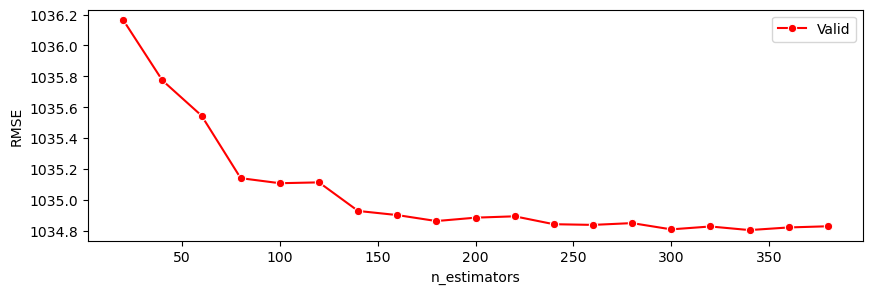

In [15]:
plt.figure(figsize= (10,3), dpi= 100)
#sns.lineplot(x= est_results['estimators'], y= est_results['train'], color = 'orange', marker= 'o', label= 'Train')
sns.lineplot(x= est_results['estimators'], y= est_results['valid'], color = 'red', marker= 'o', label= 'Valid')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.legend()
plt.show()

RMSE **(1034.837)** on Validation gets stabalized at around **n_estimators = 260**

In [16]:
def depth_score(data, min_r=1, max_r=10):
    
    X = data.drop(columns = 'Item_Outlet_Sales', axis= 1)
    Y = data['Item_Outlet_Sales']
    
    KF = KFold(n_splits= 5, shuffle= True, random_state= 0)
    
    results= []
    
    for depth in tqdm_notebook(range(min_r, max_r, 1), desc="Processing", leave=True):
        x = {}
        train_score = []
        val_score = []
        
        for i, (train_index, val_index) in enumerate(KF.split(X, Y)):
            xtr, xval = X.iloc[train_index], X.iloc[val_index]
            ytr, yval = Y.iloc[train_index], Y.iloc[val_index]
        
            model= RandomForestRegressor(random_state= 0,
                                     n_estimators= 260,
                                     max_depth= depth,
                                     min_samples_split= 5,
                                     min_samples_leaf= 5)
    
            model.fit(xtr, ytr)

            train_preds = model.predict(xtr)
            val_preds = model.predict(xval)

            train_rmse = np.sqrt(mse(ytr, train_preds))
            val_rmse = np.sqrt(mse(yval, val_preds))

            train_score.append(train_rmse)
            val_score.append(val_rmse)
            
            
        mean_score_train = np.mean(train_score)
        mean_score_valid = np.mean(val_score)

        print('With max_depth:\t' + str(depth) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
                 
        x['max_depth'] = depth
        x['train'] = mean_score_train
        x['valid'] = mean_score_valid
    
        results.append(x)
        
    return pd.DataFrame(results)

In [17]:
depth_results = depth_score(scaled_df, min_r=1, max_r=30)

Processing:   0%|          | 0/29 [00:00<?, ?it/s]

With max_depth:	1	Mean_RMSLE_Train:	1408.8235914567	Mean_RMSLE_Valid:	1411.6001579190827
With max_depth:	2	Mean_RMSLE_Train:	1184.279927691666	Mean_RMSLE_Valid:	1187.8659476788412
With max_depth:	3	Mean_RMSLE_Train:	1100.3799224290592	Mean_RMSLE_Valid:	1104.3073291388841
With max_depth:	4	Mean_RMSLE_Train:	1038.7849549260086	Mean_RMSLE_Valid:	1046.578397813623
With max_depth:	5	Mean_RMSLE_Train:	1018.2795062185263	Mean_RMSLE_Valid:	1034.8371042132535
With max_depth:	6	Mean_RMSLE_Train:	1002.3486123711443	Mean_RMSLE_Valid:	1033.0066653043682
With max_depth:	7	Mean_RMSLE_Train:	982.343783962132	Mean_RMSLE_Valid:	1033.7381533218615
With max_depth:	8	Mean_RMSLE_Train:	958.9489055423977	Mean_RMSLE_Valid:	1035.6308920067972
With max_depth:	9	Mean_RMSLE_Train:	932.6692298557833	Mean_RMSLE_Valid:	1037.9879136144536
With max_depth:	10	Mean_RMSLE_Train:	905.0613570080895	Mean_RMSLE_Valid:	1040.5137364468167
With max_depth:	11	Mean_RMSLE_Train:	877.847387625967	Mean_RMSLE_Valid:	1043.222372036527

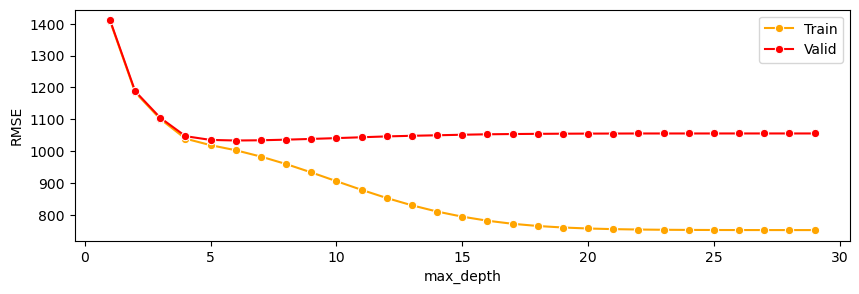

In [18]:
plt.figure(figsize= (10,3), dpi= 100)
sns.lineplot(x= depth_results['max_depth'], y= depth_results['train'], color = 'orange', marker= 'o', label= 'Train')
sns.lineplot(x= depth_results['max_depth'], y= depth_results['valid'], color = 'red', marker= 'o', label= 'Valid')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.legend()
plt.show()

At **max_depth = 6** aldation RMSE **(1033.00)** is lowest. after this point the models is overfitting on training data.

### 3. min_samples_leaf

In [4]:
def min_leaf_score(data, min_r=1, max_r=10):
    
    X = data.drop(columns = 'Item_Outlet_Sales', axis= 1)
    Y = data['Item_Outlet_Sales']
    
    KF = KFold(n_splits= 5, shuffle= True, random_state= 0)
    
    results= []
    
    for leaf in tqdm_notebook(range(min_r, max_r, 1), desc="Processing", leave=True):
        x = {}
        train_score = []
        val_score = []
        
        for i, (train_index, val_index) in enumerate(KF.split(X, Y)):
            xtr, xval = X.iloc[train_index], X.iloc[val_index]
            ytr, yval = Y.iloc[train_index], Y.iloc[val_index]
        
            model= RandomForestRegressor(random_state= 0,
                                     n_estimators= 260,
                                     max_depth= 6,
                                     min_samples_split= 5,
                                     min_samples_leaf= leaf)
    
            model.fit(xtr, ytr)

            train_preds = model.predict(xtr)
            val_preds = model.predict(xval)

            train_rmse = np.sqrt(mse(ytr, train_preds))
            val_rmse = np.sqrt(mse(yval, val_preds))

            train_score.append(train_rmse)
            val_score.append(val_rmse)
            
            
        mean_score_train = np.mean(train_score)
        mean_score_valid = np.mean(val_score)

        print('With min_samples_leaf:\t' + str(leaf) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
                 
        x['min_leaf'] = leaf
        x['train'] = mean_score_train
        x['valid'] = mean_score_valid
    
        results.append(x)
        
    return pd.DataFrame(results)

In [5]:
leaf_results = min_leaf_score(scaled_df, min_r= 1, max_r= 30)

Processing:   0%|          | 0/29 [00:00<?, ?it/s]

With min_samples_leaf:	1	Mean_RMSLE_Train:	1001.2037188838107	Mean_RMSLE_Valid:	1033.5680320399401
With min_samples_leaf:	2	Mean_RMSLE_Train:	1001.3479208412773	Mean_RMSLE_Valid:	1033.4411003923774
With min_samples_leaf:	3	Mean_RMSLE_Train:	1001.6211400364485	Mean_RMSLE_Valid:	1033.2984170612374
With min_samples_leaf:	4	Mean_RMSLE_Train:	1002.0085107417821	Mean_RMSLE_Valid:	1033.2149477393523
With min_samples_leaf:	5	Mean_RMSLE_Train:	1002.3486123711443	Mean_RMSLE_Valid:	1033.0066653043682
With min_samples_leaf:	6	Mean_RMSLE_Train:	1002.7431138281515	Mean_RMSLE_Valid:	1032.8459841028598
With min_samples_leaf:	7	Mean_RMSLE_Train:	1003.1237557255924	Mean_RMSLE_Valid:	1032.6978948168482
With min_samples_leaf:	8	Mean_RMSLE_Train:	1003.5030080119208	Mean_RMSLE_Valid:	1032.5688196627943
With min_samples_leaf:	9	Mean_RMSLE_Train:	1003.8512923111041	Mean_RMSLE_Valid:	1032.5465398365516
With min_samples_leaf:	10	Mean_RMSLE_Train:	1004.2465381851432	Mean_RMSLE_Valid:	1032.5966323635914
With min_

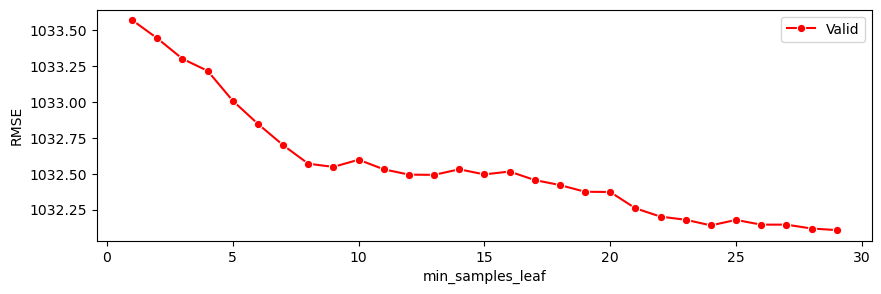

In [7]:
plt.figure(figsize= (10,3), dpi= 100)
#sns.lineplot(x= leaf_results['min_leaf'], y= leaf_results['train'], color = 'orange', marker= 'o', label= 'Train')
sns.lineplot(x= leaf_results['min_leaf'], y= leaf_results['valid'], color = 'red', marker= 'o', label= 'Valid')
plt.xlabel('min_samples_leaf')
plt.ylabel('RMSE')
plt.legend()
plt.show()

There's no significant change in the RMSE because of this parameter so we will fix the **min_samples_leaf = 24** at valid **RMSE = 1032.13**

### 4. min_samples_split

In [11]:
def min_split_score(data, min_r=1, max_r=10):
    
    X = data.drop(columns = 'Item_Outlet_Sales', axis= 1)
    Y = data['Item_Outlet_Sales']
    
    KF = KFold(n_splits= 5, shuffle= True, random_state= 0)
    
    results= []
    
    for splits in tqdm_notebook(range(min_r, max_r, 1), desc="Processing", leave=True):
        x = {}
        train_score = []
        val_score = []
        
        for i, (train_index, val_index) in enumerate(KF.split(X, Y)):
            xtr, xval = X.iloc[train_index], X.iloc[val_index]
            ytr, yval = Y.iloc[train_index], Y.iloc[val_index]
        
            model= RandomForestRegressor(random_state= 0,
                                     n_estimators= 260,
                                     max_depth= 6,
                                     min_samples_split= splits,
                                     min_samples_leaf= 24)
    
            model.fit(xtr, ytr)

            train_preds = model.predict(xtr)
            val_preds = model.predict(xval)

            train_rmse = np.sqrt(mse(ytr, train_preds))
            val_rmse = np.sqrt(mse(yval, val_preds))

            train_score.append(train_rmse)
            val_score.append(val_rmse)
            
            
        mean_score_train = np.mean(train_score)
        mean_score_valid = np.mean(val_score)

        print('With min_samples_split:\t' + str(splits) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
                 
        x['min_splits'] = splits
        x['train'] = mean_score_train
        x['valid'] = mean_score_valid
    
        results.append(x)
        
    return pd.DataFrame(results)

In [12]:
split_results = min_split_score(scaled_df, min_r= 1, max_r= 30)

Processing:   0%|          | 0/29 [00:00<?, ?it/s]

With min_samples_split:	1	Mean_RMSLE_Train:	1008.8928896413994	Mean_RMSLE_Valid:	1032.1397615733613
With min_samples_split:	2	Mean_RMSLE_Train:	1008.8928896413994	Mean_RMSLE_Valid:	1032.1397615733613
With min_samples_split:	3	Mean_RMSLE_Train:	1008.8928896413994	Mean_RMSLE_Valid:	1032.1397615733613
With min_samples_split:	4	Mean_RMSLE_Train:	1008.8928896413994	Mean_RMSLE_Valid:	1032.1397615733613
With min_samples_split:	5	Mean_RMSLE_Train:	1008.8928896413994	Mean_RMSLE_Valid:	1032.1397615733613
With min_samples_split:	6	Mean_RMSLE_Train:	1008.8928896413994	Mean_RMSLE_Valid:	1032.1397615733613
With min_samples_split:	7	Mean_RMSLE_Train:	1008.8928896413994	Mean_RMSLE_Valid:	1032.1397615733613
With min_samples_split:	8	Mean_RMSLE_Train:	1008.8928896413994	Mean_RMSLE_Valid:	1032.1397615733613
With min_samples_split:	9	Mean_RMSLE_Train:	1008.8928896413994	Mean_RMSLE_Valid:	1032.1397615733613
With min_samples_split:	10	Mean_RMSLE_Train:	1008.8928896413994	Mean_RMSLE_Valid:	1032.1397615733613

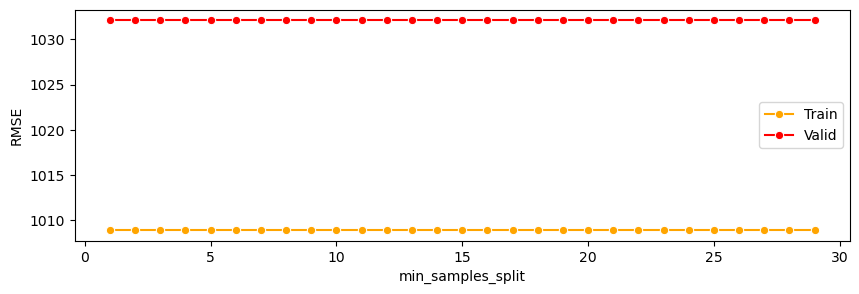

In [13]:
plt.figure(figsize= (10,3), dpi= 100)
sns.lineplot(x= split_results['min_splits'], y= split_results['train'], color = 'orange', marker= 'o', label= 'Train')
sns.lineplot(x= split_results['min_splits'], y= split_results['valid'], color = 'red', marker= 'o', label= 'Valid')
plt.xlabel('min_samples_split')
plt.ylabel('RMSE')
plt.legend()
plt.show()

This hyperparameter is not affecting the RMSLE score at all. So we will keep it default value **min_samples_split = 5**.

here are the final hyperparameters for the tuned model:
* **n_estimators :** 260
* **max_depth :** 6
* **min_samples_split :** 5
* **min_samples_leaf :** 24
